# Task 3

# Imports

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})
## add any other additional packages that you need. You are free to use any packages for vizualization.

## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

In [2]:
## Depending on the permissions that you provided to your bucket you might need to provide your aws credentials
## to read from the bucket, if so provide with your credentials and pass as storage_options=aws_credentials
# aws_credentials = {"key": "","secret": "","token":""}
df = pd.read_csv("ml_data_SYD.csv", index_col=0, parse_dates=True)

In [6]:
# @todo - Remove on AWS before running and submitting
#df = df.sample(frac=0.2)

In [7]:
# 1. Drop rows with nans
df = df.dropna(axis=0, how='any')
df = df.sort_index(ascending=True)

In [8]:
# 2. split into train and test
train, test = train_test_split(df, test_size=0.2, random_state=123, shuffle=False)

# Define Target Column
target_col = 'observed_rainfall'

Text(0, 0.5, 'Count')

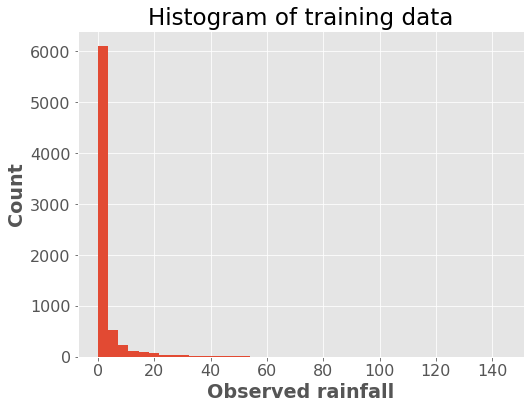

In [9]:
train[target_col].hist(bins=40)
plt.title("Histogram of training data")
plt.xlabel("Observed rainfall")
plt.ylabel("Count")

Text(0, 0.5, 'Rainfall in mm')

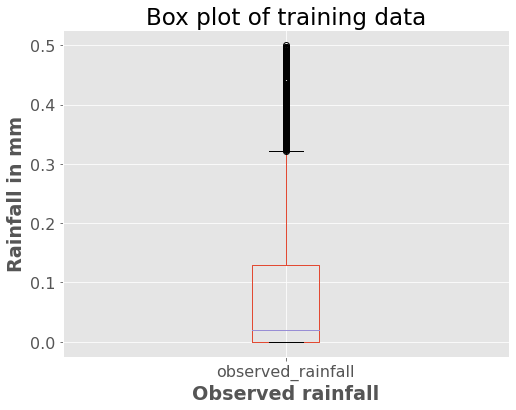

In [26]:
pd.DataFrame(train[train[target_col]<0.5]).boxplot(column=target_col).plot()
plt.title("Box plot of training data")
plt.xlabel("Observed rainfall")
plt.ylabel("Rainfall in mm")

In [27]:
# Cleaning outlier data from training dataset due to high number of outliers that can be observed in the box-plot
train = train[train[target_col]<0.5]

In [28]:
# Split into X and y
X_cols = [col for col in train.columns if col != target_col]
X_train, y_train = train[X_cols], train[target_col]
X_test, y_test = test[X_cols], test[target_col]

In [29]:
# 4. Fit a Random Forest Regressor and tune the model
from collections import defaultdict

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

results = defaultdict(dict)

model_pipeline = Pipeline(steps=[('fit', RandomForestRegressor(random_state=123))])

param_dist = {"fit__n_estimators": [ 100,300, 500, 700, 1000],
              "fit__max_depth": [ 3,5,7,9,11],
              }

cv_model = RandomizedSearchCV(model_pipeline, param_dist,
                        cv=5,
                        return_train_score=True,
                        scoring='neg_root_mean_squared_error' )

solution_space = cv_model.fit(X_train, y_train)

print("Best parameters: ",solution_space.best_params_)
print("Best RMSE Score: ",-1*solution_space.best_score_)

best_predictor_model = cv_model.best_estimator_.named_steps['fit']
best_predictor_model

/Users/bulut/miniconda3/envs/574/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters:  {'fit__n_estimators': 100, 'fit__max_depth': 3}
Best RMSE Score:  0.12412927558321396


RandomForestRegressor(max_depth=3, random_state=123)

<AxesSubplot:title={'center':'Actual vs Predicted'}, xlabel='Actual', ylabel='Predicted'>

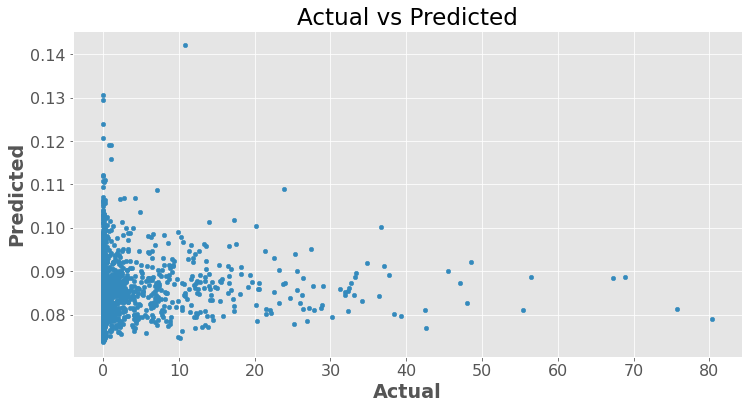

In [31]:
best_model = best_predictor_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

predicted_values = pd.DataFrame([y_test.tolist(), y_pred]).T
predicted_values.columns = ['Actual','Predicted']
predicted_values.plot(x="Actual", y="Predicted",
                      kind="scatter",figsize=(12,6),
                      title='Actual vs Predicted')

In [32]:
from sklearn.metrics import mean_squared_error
test_rmse = (mean_squared_error(y_test, y_pred))**0.5
print("Test RMSE of Random Forest Regressor: ",test_rmse)

Test RMSE:  7.641038588614402


In [34]:
# 6. Discussion of the results
# noresm2_model_preds = X_test['NorESM2-LM']
# rmse_of_noresm2_model = (mean_squared_error(y_test, noresm2_model_preds))**0.5
# print("Test RMSE of noresm2-lm: ",rmse_of_noresm2_model)

for model in X_test.columns:
    model_dat = X_test[f'{model}']
    print(f'Test RMSE of {model}: {(mean_squared_error(y_test, model_dat))**0.5}')

Test RMSE of noresm2-lm:  9.003729868724045


> Our model has beaten the individual climate models by a rmse score of 1.5. Our model has improved performance over the individual climate model since it is using advanced machine learning and we are also both tuning parameters of the model and at the same time cleaning the data using preprocessing.

## Part 2:

### Preparation for deploying model next week

***NOTE: Complete task 4 from the milestone3 before coming here***

We’ve found the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

In [ ]:
print(f"Train RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

In [28]:
# ready to deploy
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3 under output folder. You choose how you want to upload it (using CLI, SDK, or web console).***